In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
stores = pd.read_csv('new_data/stores.csv')
promotions = pd.read_csv('new_data/promotions.csv', parse_dates=['Date'])
df = pd.read_csv('new_data/dataset.csv', parse_dates=['Date'], low_memory=False)

df.drop(columns=['Customers'], inplace=True)

# Sort df by Date
df = df.sort_values(by='Date')

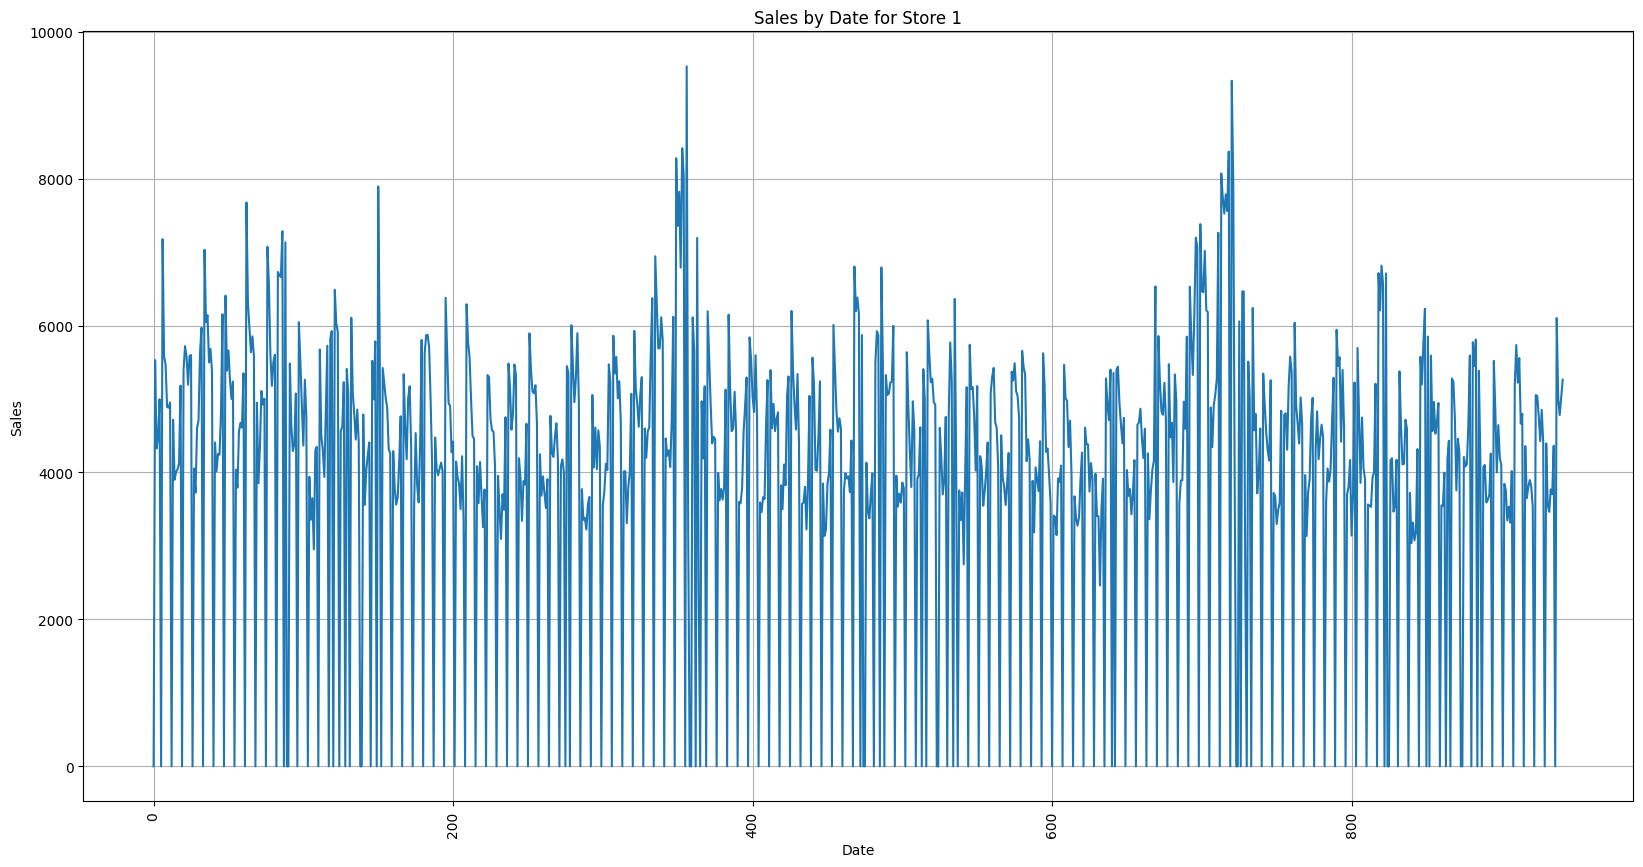

In [3]:
def plot_store_time_series(store_id, df):
    store_data = df[df['Store'] == store_id]
    x = np.arange(len(store_data['Date'].unique()))
    y = store_data.groupby('Date')['Sales'].sum()

    plt.figure(figsize=(20, 10))
    plt.plot(x, y)
    plt.title(f'Sales by Date for Store {store_id}')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.xticks(rotation=90)
    plt.grid()
    plt.savefig(f'time_series_plot.png')
    plt.show()

plot_store_time_series(1, df)

Outliers identification using z-score

In [4]:
def identify_outliers(train_df):
    df = train_df.copy()

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Store', 'Date'])
    window = 7

    df['rolling_mean'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())
    df['rolling_std'] = df.groupby('Store')['Sales'].transform(lambda x: x.rolling(window=window, min_periods=1).std())

    # Avoid division by zero (std can be 0 in early days)
    df['rolling_std'] = df['rolling_std'].replace(0, np.nan)

    df['z_score'] = (df['Sales'] - df['rolling_mean']) / df['rolling_std']
    df['is_outlier'] = df['z_score'].abs() > 2
    df.reset_index(drop=True, inplace=True)

    outliers = df[df['is_outlier'] == True]
    print(outliers[['Date', 'Store', 'Sales', 'z_score']])

    return df

outliers = identify_outliers(df)

              Date  Store  Sales   z_score
12      2013-01-13      1      0 -2.115043
19      2013-01-20      1      0 -2.182064
26      2013-01-27      1      0 -2.260209
33      2013-02-03      1      0 -2.074656
40      2013-02-10      1      0 -2.202669
...            ...    ...    ...       ...
1017175 2015-06-28   1115      0 -2.188703
1017182 2015-07-05   1115      0 -2.036081
1017189 2015-07-12   1115      0 -2.183078
1017196 2015-07-19   1115      0 -2.027383
1017203 2015-07-26   1115      0 -2.192134

[83634 rows x 4 columns]


In [5]:
display(outliers)

,Store,Date,Sales,Open,rolling_mean,rolling_std,z_score,is_outlier
0,1,2013-01-01,0,0,0.000000,NaN,NaN,False
1,1,2013-01-02,5530,1,2765.000000,3910.300500,0.707107,False
2,1,2013-01-03,4327,1,3285.666667,2908.351137,0.358049,False
3,1,2013-01-04,4486,1,3585.750000,2449.327306,0.367550,False
4,1,2013-01-05,4997,1,3868.000000,2213.081223,0.510148,False
...,...,...,...,...,...,...,...,...
1017204,1115,2015-07-27,10712,1,5713.000000,3156.415847,1.583758,False
1017205,1115,2015-07-28,8093,1,6144.285714,3259.135709,0.597924,False
1017206,1115,2015-07-29,7661,1,6475.571429,3281.775478,0.361216,False
1017207,1115,2015-07-30,8405,1,6797.714286,3354.364506,0.479163,False


In [6]:
display(df)

,Store,Date,Sales,Open
1017208,1115,2013-01-01,0,0
1016473,379,2013-01-01,0,0
1016472,378,2013-01-01,0,0
1016471,377,2013-01-01,0,0
1016470,376,2013-01-01,0,0
...,...,...,...,...
745,746,2015-07-31,9082,1
746,747,2015-07-31,10708,1
747,748,2015-07-31,7481,1
741,742,2015-07-31,10460,1


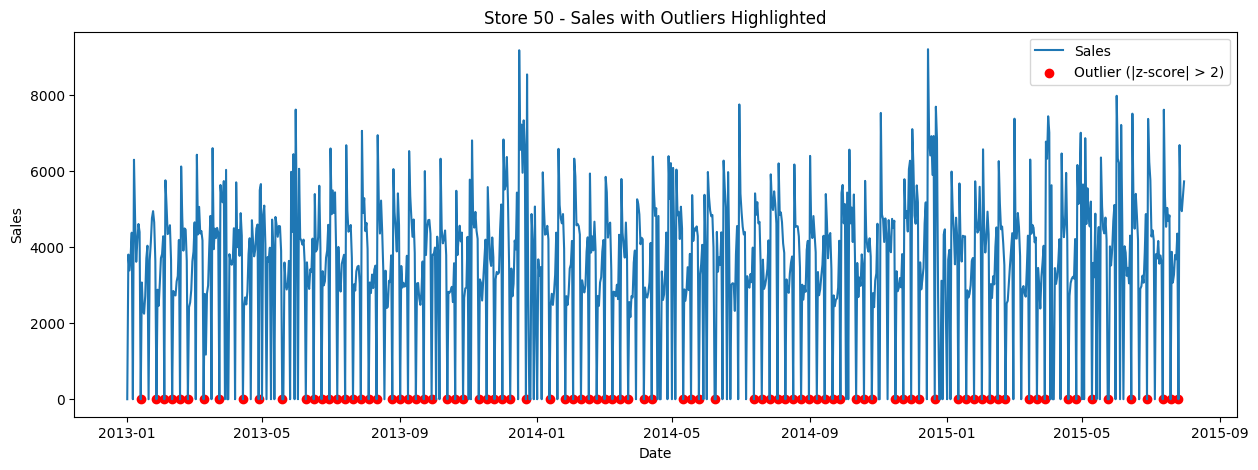

In [7]:
def plot_outliers(store_id, outliers):
    # Use df, which contains z_score and is_outlier columns
    store_data = outliers[outliers['Store'] == store_id].copy()
    plt.figure(figsize=(15, 5))
    plt.plot(store_data['Date'], store_data['Sales'], label='Sales')
    # Plot outliers (z_score > 2 or < -2)
    outlier_mask = store_data['is_outlier']
    plt.scatter(store_data.loc[outlier_mask, 'Date'], 
                store_data.loc[outlier_mask, 'Sales'], 
                color='red', label='Outlier (|z-score| > 2)')
    plt.legend()
    plt.title(f"Store {store_id} - Sales with Outliers Highlighted")
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.savefig("Outliers.png")
    plt.show()

plot_outliers(50, outliers)

             Date  Store  Sales   z_score
22     2013-01-28      1   4055 -2.166048
52     2013-03-04      1   7675  2.094888
64     2013-03-18      1   7072  2.027046
103    2013-05-06      1   4568 -2.063948
115    2013-05-22      1   3559 -2.005410
...           ...    ...    ...       ...
844291 2015-03-30   1115  11641  2.054756
844351 2015-06-15   1115  10853  2.021938
844363 2015-06-29   1115  11006  2.189264
844375 2015-07-13   1115  10598  2.125102
844387 2015-07-27   1115  10712  2.157304

[37127 rows x 4 columns]


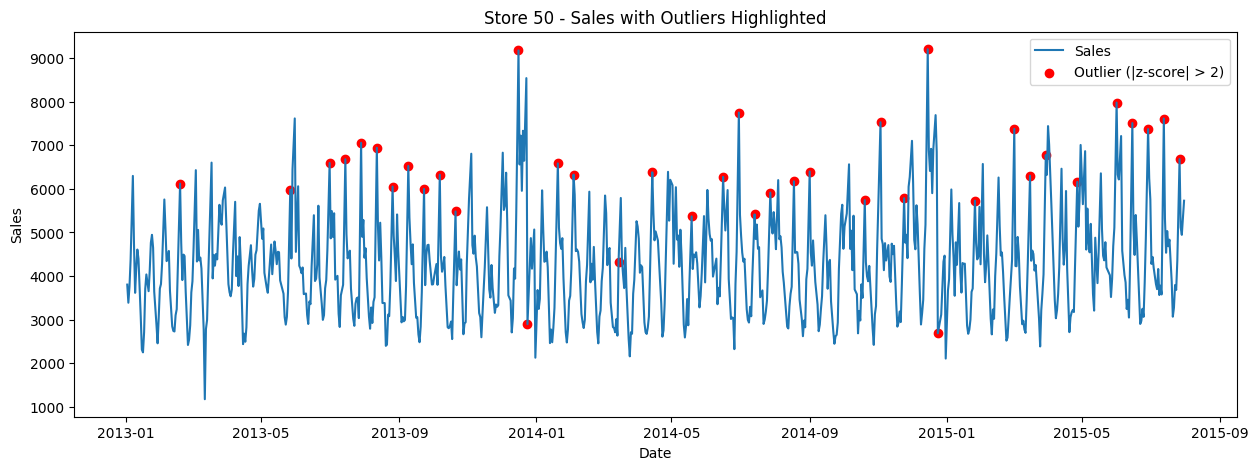

In [8]:
# Removing all closed stores
df = df[df['Open'] == 1]
outliers = identify_outliers(df)
plot_outliers(50, outliers)

In [9]:
df.drop(columns=['Open'], inplace=True)
display(df)

,Store,Date,Sales
1016447,353,2013-01-01,3139
1016429,335,2013-01-01,2401
1016606,512,2013-01-01,2646
1016588,494,2013-01-01,3113
1016624,530,2013-01-01,2907
...,...,...,...
745,746,2015-07-31,9082
746,747,2015-07-31,10708
747,748,2015-07-31,7481
741,742,2015-07-31,10460


In [10]:
def get_promo_dates(stores_df: pd.DataFrame) -> pd.DataFrame:
    stores_df = stores_df.copy()
    stores_df = stores_df.dropna(subset=['PromoInterval', 'PromoSinceYear', 'PromoSinceWeek'])

    month_map = {
        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
        'Sept': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
    }

    promo_rows = []
    for _, row in stores_df.iterrows():
        store_id = row['Store']
        promo_year = int(row['PromoSinceYear'])
        promo_week = int(row['PromoSinceWeek'])
        months = [m.strip() for m in row['PromoInterval'].split(',')]

        promo_start_date = pd.to_datetime(f'{promo_year}-W{int(promo_week):02d}-1', format='%Y-W%W-%w')

        for year in range(promo_year, 2016):
            for month in months:
                month_num = month_map[month]
                promo_date = pd.Timestamp(year=year, month=month_num, day=1)

                if promo_date >= promo_start_date:
                    month_dates = pd.date_range(start=promo_date, end=promo_date + pd.offsets.MonthEnd(0), freq='D')
                    for d in month_dates:
                        promo_rows.append({'Store': store_id, 'Date': pd.to_datetime(d)})

    promo_df = pd.DataFrame(promo_rows)
    return promo_df

promo_dates_df = get_promo_dates(stores)
display(promo_dates_df)
# promo_dates_df.to_csv('new_data/promo_dates.csv', index=False)

,Store,Date
0,2,2010-04-01
1,2,2010-04-02
2,2,2010-04-03
3,2,2010-04-04
4,2,2010-04-05
...,...,...
256755,1115,2015-12-27
256756,1115,2015-12-28
256757,1115,2015-12-29
256758,1115,2015-12-30


In [11]:
# Add promo_dates_df to promotions
promotions = pd.merge(promotions, promo_dates_df, on=['Store', 'Date'], how='outer')
promotions = promotions.drop_duplicates(subset=['Store', 'Date'])
promotions = promotions.sort_values(by=['Store', 'Date'])
display(promotions)

,Store,Date
0,1,2013-01-07
1,1,2013-01-08
2,1,2013-01-09
3,1,2013-01-10
4,1,2013-01-11
...,...,...
577877,1115,2015-12-27
577878,1115,2015-12-28
577879,1115,2015-12-29
577880,1115,2015-12-30


In [12]:
# Merge stores with df
df = pd.merge(df, stores, on='Store', how='left')
display(df)

,Store,Date,Sales,Assortment,CompetitionDistance,PromoSinceWeek,PromoSinceYear,PromoInterval
0,353,2013-01-01,3139,Medium,900.0,14.0,2013.0,"Feb,May,Aug,Nov"
1,335,2013-01-01,2401,Small,90.0,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,512,2013-01-01,2646,Medium,590.0,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,494,2013-01-01,3113,Small,1260.0,NaN,NaN,NaN
4,530,2013-01-01,2907,Large,18160.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
844387,746,2015-07-31,9082,Large,4330.0,35.0,2011.0,"Mar,Jun,Sept,Dec"
844388,747,2015-07-31,10708,Large,45740.0,NaN,NaN,NaN
844389,748,2015-07-31,7481,Small,2380.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
844390,742,2015-07-31,10460,Large,4380.0,NaN,NaN,NaN


In [13]:
df.drop(columns=['PromoSinceWeek', 'PromoSinceYear', 'PromoInterval'], inplace=True)
display(df)

,Store,Date,Sales,Assortment,CompetitionDistance
0,353,2013-01-01,3139,Medium,900.0
1,335,2013-01-01,2401,Small,90.0
2,512,2013-01-01,2646,Medium,590.0
3,494,2013-01-01,3113,Small,1260.0
4,530,2013-01-01,2907,Large,18160.0
...,...,...,...,...,...
844387,746,2015-07-31,9082,Large,4330.0
844388,747,2015-07-31,10708,Large,45740.0
844389,748,2015-07-31,7481,Small,2380.0
844390,742,2015-07-31,10460,Large,4380.0


In [14]:
# Merge df with promotions on 'Store' and 'Date', keeping only rows present in df
df = pd.merge(df, promotions, on=['Store', 'Date'], how='left', indicator='promo_merge')
df['Promo'] = (df['promo_merge'] == 'both').astype(int)
df.drop(columns=['promo_merge'], inplace=True)
display(df)

,Store,Date,Sales,Assortment,CompetitionDistance,Promo
0,353,2013-01-01,3139,Medium,900.0,0
1,335,2013-01-01,2401,Small,90.0,0
2,512,2013-01-01,2646,Medium,590.0,0
3,494,2013-01-01,3113,Small,1260.0,0
4,530,2013-01-01,2907,Large,18160.0,0
...,...,...,...,...,...,...
844387,746,2015-07-31,9082,Large,4330.0,1
844388,747,2015-07-31,10708,Large,45740.0,1
844389,748,2015-07-31,7481,Small,2380.0,1
844390,742,2015-07-31,10460,Large,4380.0,1


In [15]:
# Add day of week as a integer
df['DayOfWeek'] = df['Date'].dt.dayofweek
display(df)

,Store,Date,Sales,Assortment,CompetitionDistance,Promo,DayOfWeek
0,353,2013-01-01,3139,Medium,900.0,0,1
1,335,2013-01-01,2401,Small,90.0,0,1
2,512,2013-01-01,2646,Medium,590.0,0,1
3,494,2013-01-01,3113,Small,1260.0,0,1
4,530,2013-01-01,2907,Large,18160.0,0,1
...,...,...,...,...,...,...,...
844387,746,2015-07-31,9082,Large,4330.0,1,4
844388,747,2015-07-31,10708,Large,45740.0,1,4
844389,748,2015-07-31,7481,Small,2380.0,1,4
844390,742,2015-07-31,10460,Large,4380.0,1,4


In [16]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['Assortment'] = encoder.fit_transform(df['Assortment'])

In [17]:
display(df.head())

,Store,Date,Sales,Assortment,CompetitionDistance,Promo,DayOfWeek
0,353,2013-01-01,3139,1,900.0,0,1
1,335,2013-01-01,2401,2,90.0,0,1
2,512,2013-01-01,2646,1,590.0,0,1
3,494,2013-01-01,3113,2,1260.0,0,1
4,530,2013-01-01,2907,0,18160.0,0,1


In [18]:
print(encoder.inverse_transform([0, 1, 2]))

['Large' 'Medium' 'Small']


In [27]:
df = df.sort_values(['Store', 'Date'])
lags = [1, 7, 14]

for lag in lags:
    df[f'Sales_lag_{lag}'] = df.groupby('Store')['Sales'].shift(lag)

df = df.dropna(subset=[f'Sales_lag_{lag}' for lag in lags])
df['Sales_ma_7'] = df.groupby('Store')['Sales'].shift(1).rolling(window=7).mean()
df['Sales_ma_14'] = df.groupby('Store')['Sales'].shift(1).rolling(window=14).mean()

display(df.head(10))

,Store,Date,Sales,Assortment,CompetitionDistance,Promo,DayOfWeek,Sales_lag_1,Sales_lag_7,Sales_lag_14,Sales_ma_7,Sales_ma_14
15903,1,2013-01-18,4127,2,1270.0,0,4,4044.0,4892.0,5530.0,NaN,NaN
17198,1,2013-01-19,5182,2,1270.0,0,5,4127.0,4881.0,4327.0,NaN,NaN
18134,1,2013-01-21,5394,2,1270.0,1,0,5182.0,4952.0,4486.0,NaN,NaN
19294,1,2013-01-22,5720,2,1270.0,1,1,5394.0,4717.0,4997.0,NaN,NaN
20537,1,2013-01-23,5578,2,1270.0,1,2,5720.0,3900.0,7176.0,NaN,NaN
21457,1,2013-01-24,5195,2,1270.0,1,3,5578.0,4008.0,5580.0,NaN,NaN
22565,1,2013-01-25,5586,2,1270.0,1,4,5195.0,4044.0,5471.0,NaN,NaN
23672,1,2013-01-26,5598,2,1270.0,0,5,5586.0,4127.0,4892.0,5254.571429,NaN
24801,1,2013-01-28,4055,2,1270.0,0,0,5598.0,5182.0,4881.0,5464.714286,NaN
25908,1,2013-01-29,3725,2,1270.0,0,1,4055.0,5394.0,4952.0,5303.714286,NaN


In [28]:
def split_dataset(df):
    df = df.copy()
    train = df[df['Date'] < '2015-03-01']
    train = train.drop(columns='Date')
    test = df[df['Date'] >= '2015-03-01']
    test = test.drop(columns='Date')

    X_train, y_train = train.drop(columns='Sales'), train['Sales']
    X_test, y_test = test.drop(columns='Sales'), test['Sales']

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = split_dataset(df)

In [20]:
import optuna

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42,
        'n_jobs': -1,
        'tree_method': 'hist',
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)

    return rmse

In [29]:
import json

try:
    with open('best_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    best_params = None    

if not best_params:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    best_params = study.best_params
print(f"Best parameters: {best_params}")

Best parameters: {'n_estimators': 475, 'max_depth': 9, 'learning_rate': 0.22594731375525895, 'subsample': 0.9841937224705313, 'colsample_bytree': 0.8115993503676006, 'min_child_weight': 9, 'gamma': 1.0508620811373048, 'reg_alpha': 0.2682513430967105, 'reg_lambda': 1.962135997883376, 'tree_method': 'hist', 'random_state': 42, 'n_jobs': -1}


In [30]:
best_params['tree_method'] = 'hist'
best_params['random_state'] = 42
best_params['n_jobs'] = -1

model = XGBRegressor(**best_params)

model.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False)

y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

In [31]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Mean Sales: {y_test.mean():.2f}")
print(f"Error percentage: {rmse / y_test.mean() * 100:.2f}%")

Test RMSE: 1000.72
Mean Sales: 7205.45
Error percentage: 13.89%


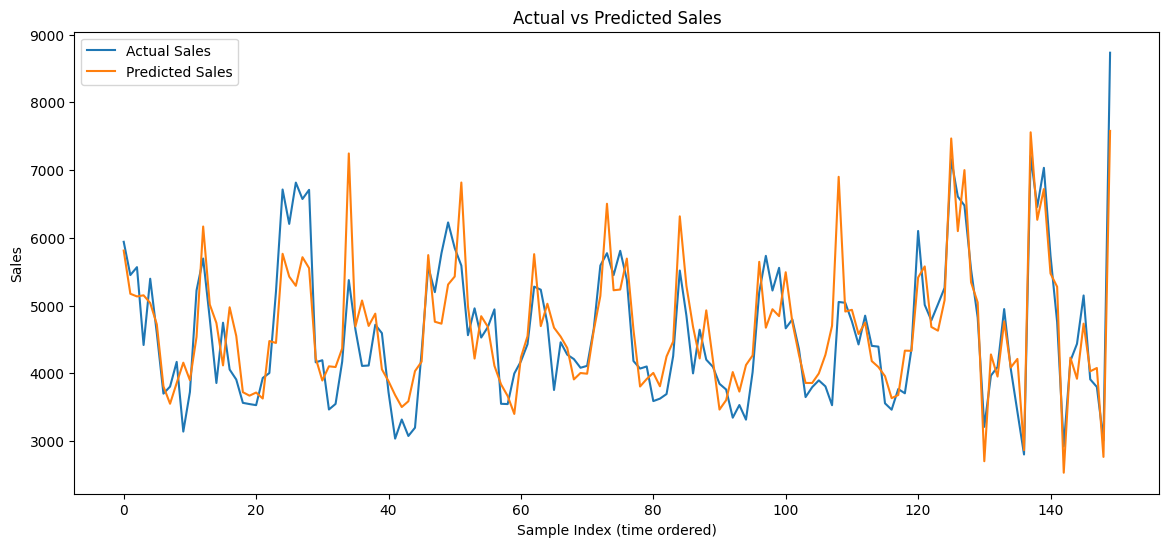

In [34]:
def plot_actual_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(14,6))
    plt.plot(y_test.values, label='Actual Sales')
    plt.plot(y_pred, label='Predicted Sales')
    plt.title('Actual vs Predicted Sales')
    plt.xlabel('Sample Index (time ordered)')
    plt.ylabel('Sales')
    plt.legend()
    plt.savefig('actual_vs_predicted.png')
    plt.show()

n = 150

plot_actual_vs_predicted(y_test[:n], y_pred[:n])

In [25]:
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)